<a href="https://colab.research.google.com/github/jimzhang629/RippleNet/blob/master/edited_RippleNet_manuscript_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RippleNet_manuscript_figures Confusion Matrix

Change RippleNet manuscript figures code so that it works for our time-sliced data.

Author: Espen Hagen (<https://github.com/espenhgn>)

LICENSE: <https://github.com/CINPLA/RippleNet/blob/master/LICENSE>

In [1]:
# allow running on Google Colab, using data on Google Drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/My\ Drive/RippleNet
    %tensorflow_version 2.x
except:
    pass

Mounted at /content/gdrive
/content/gdrive/My Drive/RippleNet


In [2]:
%matplotlib inline

In [3]:
import os
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tensorflow
from tensorflow import keras
import h5py
from glob import glob
import pandas as pd
import pickle
from matplotlib import colors
from ripplenet.common import *

In [4]:
# make figures appear consistent across plots/notebooks
plt.rcParams.update(rcParams)

In [5]:
# pandas print precision
pd.set_option('precision', 3)

In [6]:
# set random seeds
np.random.seed(1478)
tensorflow.random.set_seed(14785)

In [7]:
# create folder for figure files
if not os.path.isdir('figures'):
    os.mkdir('figures')

# load validation data

In [8]:
# select species for validation stats (mouse, rat or both)
mouse = True
rat = False

# data string
dataset = 'validation'

In [9]:
# select dataset (may have generated different sets.)
dataset_index = 0 

In [10]:
if mouse:
    # load mouse validation datas with labels
    f = h5py.File(os.path.join('data', '{}_{:02}.h5'.format(dataset, dataset_index)), 'r')
    print(f)
    X0 = f['X0'][:] # Raw LFP segments
    X1 = f['X1'][:] # Band-pass filtered LFP segments
    S = f['S'][:] # Wavelet spectrograms
    Y = f['Y'][:] # Numeric labels array
    labels = f['labels'][:]
    all_labels = f['all_labels'][:]

    S_freqs = f['S_freqs'][:]
    f.close()

    
    # fix dimensionality for test set
    X_val = np.expand_dims(X0, -1)
    Y_val = Y

    # center raw data (only used for visualization)
    X0 = (X0.T - X0.mean(axis=-1)).T

    train_first_dim = int(4175*1250 / 10)
    val_first_dim = int(200*1250 / 10)

    reshaped_X_val = np.reshape(X_val, (val_first_dim, 10, 1)) #reshape so that each segment of data is only about 10ms long, instead of 1 second
    reshaped_Y_val = np.reshape(Y_val, (val_first_dim, 10, 1))
    reshaped_X0 = np.reshape(X0, (val_first_dim, 10))
    reshaped_X1 = np.reshape(X1, (val_first_dim, 10))
    reshaped_S = np.reshape(S, (val_first_dim, 10, 16))
    reshaped_Y = np.reshape(Y, (val_first_dim, 10, 1))

  

<HDF5 file "validation_00.h5" (mode r)>


In [ ]:
print(labels)
print(reshaped_X_val.shape)

[(b'm6112_session3', 607641,   -95) (b'm4031_session6', 691164,  -107)
 (b'm6112_session2', 625651,  -525) (b'm6112_session3', 754822,  -685)
 (b'm4030_session8', 743494,  -341) (b'm4106_session4', 329417, -1157)
 (b'm4214_session8', 120723, -1084) (b'm4031_session1', 583607,  -514)
 (b'm4046_session4', 138399,  -962) (b'm4046_session3', 156237,  -852)
 (b'm4028_session3', 428280, -1077) (b'm4028_session3', 259486, -1156)
 (b'm4028_session3', 328992, -1002) (b'm4214_session12', 191627, -1064)
 (b'm4214_session10', 665439, -1064) (b'm4106_session2', 505927,  -222)
 (b'm4215_session10', 514585,  -924) (b'm4215_session6', 196131, -1040)
 (b'm6102_session4',  70020,  -229) (b'm6102_session2', 250278, -1148)
 (b'm4215_session6', 741563,  -557) (b'm4031_session1', 681662, -1057)
 (b'm4106_session4', 569061,  -611) (b'm4030_session7',   3442,  -831)
 (b'm4214_session8', 249141,  -372) (b'm4046_session4', 426172,  -256)
 (b'm6102_session4', 453202, -1127) (b'm4030_session7', 182406,  -396)
 (b

In [11]:
n = 250000 / 200
print(n)
reshaped_labels = np.repeat(labels, n)
print(reshaped_labels)

1250.0
[(b'm6112_session3', 607641,  -95) (b'm6112_session3', 607641,  -95)
 (b'm6112_session3', 607641,  -95) ... (b'm4028_session5', 104249, -784)
 (b'm4028_session5', 104249, -784) (b'm4028_session5', 104249, -784)]


In [12]:
print(all_labels.shape)

(4461,)


In [ ]:
if mouse and rat:
    # load test datas with labels
    f = h5py.File(os.path.join('data', '{}_tingley_{:02}.h5'.format(dataset, dataset_index)), 'r')

    X_val = np.concatenate((X_val, np.expand_dims(f['X0'][:], -1)))
    Y_val = np.concatenate((Y_val, f['Y'][:]))

    X0 = np.concatenate((X0, f['X0'][:])) # Raw LFP segments
    X1 = np.concatenate((X1, f['X1'][:])) # Band-pass filtered LFP segments
    S = np.concatenate((S, f['S'][:])) # Wavelet spectrograms
    Y = np.concatenate((Y, f['Y'][:])) # Numeric labels array
    labels = np.concatenate((labels, f['labels'][:]))
    all_labels = np.concatenate((all_labels, f['all_labels'][:]))
    f.close()

    # center raw data (only used for visualization)
    X0 = (X0.T - X0.mean(axis=-1)).T 

In [ ]:
if rat and not mouse:
    # load test datas with labels
    f = h5py.File(os.path.join('data', '{}_tingley_{:02}.h5'.format(dataset, dataset_index)), 'r')
    
    X0 = f['X0'][:] # Raw LFP segments
    X1 = f['X1'][:] # Band-pass filtered LFP segments
    S = f['S'][:] # Wavelet spectrograms
    Y = f['Y'][:] # Numeric labels array
    labels = f['labels'][:]
    all_labels = f['all_labels'][:]
    S_freqs = f['S_freqs'][:]
    f.close()

    # fix dimensionality for test set
    X_val = np.expand_dims(X0, -1)
    Y_val = Y

    # center raw data (only used for visualization)
    X0 = (X0.T - X0.mean(axis=-1)).T

In [ ]:
# shapes of validation input/output
reshaped_X_val.shape, reshaped_Y_val.shape

((25000, 10, 1), (25000, 10, 1))

In [13]:
# some needed parameters
n_samples = reshaped_X0.shape[0] # total number of samples
Fs = 1250 # Hz, sampling freq
time = np.arange(reshaped_X0.shape[1]) / Fs
print(time)
print(reshaped_X0.shape)

[0.     0.0008 0.0016 0.0024 0.0032 0.004  0.0048 0.0056 0.0064 0.0072]
(25000, 10)


In [14]:
# width of boxcar around each labeled event
y_label_width = int(50 * Fs / 100) # 50 ms @ Fs #change this from 1000 to 10?

In [15]:
# default settings for detecting event from predictions
threshold = 0.5
distance = int(50 * Fs / 1000) # ms @ Fs, peak interdistance (1000 by default but I changed it to 10 cuz our data smaller. Prob not actually 10 though.)
width = int(20 * Fs / 1000) # ms @ Fs, peak width (also changed from 1000 to 10. Probably more like 13? Idk.)

## Figure 3:

IndexError: ignored

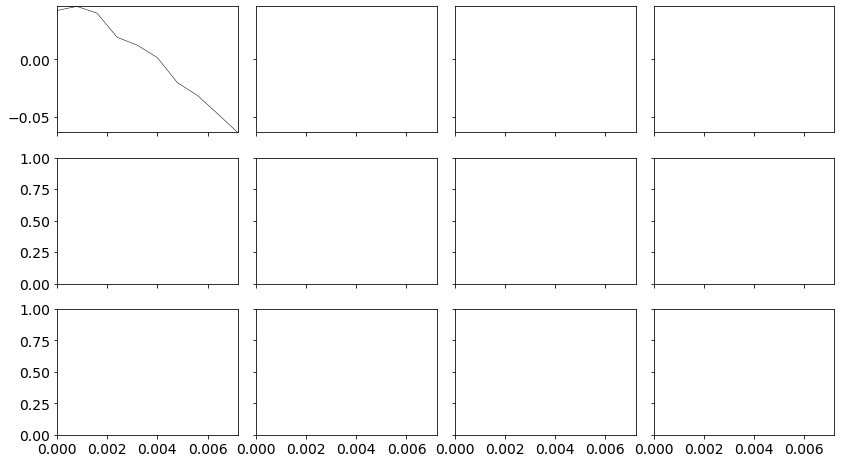

In [ ]:
ncols = 4 # number of columns (validation samples) in plot

fig, axes = plt.subplots(3, ncols, figsize=(12, 7), sharey='row', sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.2, left=0.05, right=0.95, top=0.95, bottom=0.1)

for i in range(ncols):
    # raw LFP with ripple label
    ax0 = axes[0, i]
    ax0.plot(time, reshaped_X_val[i, ] - reshaped_X_val[i, ].mean(), 'k', lw=0.5,  
             label='__nolabel__'
             #label=r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$',
            )
    
    idx = all_labels['session'] == labels['session'][i]
    lbls = all_labels['rippleLocs'][idx] - labels[i]['rippleLocs'] - labels[i]['offset']
    inds = lbls[(lbls >= 0) & (lbls < Fs)]
    ax0.plot(time[inds], reshaped_X_val[i, inds] - reshaped_X_val[i, ].mean() + 0.4, 
             'D', mec='k', mfc='w', ms=8, label='SPW-R',
             clip_on=False)
    ax0.set_title(r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
    if i == 0:
        ax0.set_ylabel('(mV)', labelpad=0)
    if i == ncols - 1:
        ax0.legend(loc=(0.95, 0.2), frameon=False, handletextpad=0)
    ax0.axis(ax0.axis('tight'))
    for spine in ['top', 'bottom', 'right']:
        ax0.spines[spine].set_visible(False)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax0.xaxis.set_ticks_position('none')    
    

    # band-pass filtered LFP
    ax1 = axes[1, i]
    ax1.plot(time, X1[i, ], 'k', lw=0.5, label=r'$\phi_\mathrm{BP}(t)$')
    ax1.set_title(r'$\phi_\mathrm{BP}^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
    ax1.axis(ax1.axis('tight'))
    if i == 0:
        ax1.set_ylabel('(mV)', labelpad=0)
    for spine in ['top', 'bottom', 'right']:
        ax1.spines[spine].set_visible(False)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.xaxis.set_ticks_position('none')    
    
    
    # Spectrograms
    ax2 = axes[2, i]

    vmin, vmax = np.exp(np.percentile(np.log(S), [1, 99]))
    im = ax2.pcolormesh(time, S_freqs, S[i, ].T, 
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                        cmap='inferno',
                        label='spectrogram',
                        rasterized=True)
    if i == ncols-1:
        rect = np.array(ax2.get_position().bounds)
        rect[0] += rect[2] + 0.01
        rect[2] = 0.01
        fig = plt.gcf()
        cax = fig.add_axes(rect)
        
        cbar = fig.colorbar(im, cax=cax, extend='both')
        cbar.set_ticks(10.**np.arange(-5, 5))
        cbar.set_label('(a.u.)', labelpad=0)
    ax2.axis(ax2.axis('tight'))
    if i == 0:
        ax2.set_ylabel('$f$ (Hz)', labelpad=0)
    ax2.set_xlabel('$t$ (s)', labelpad=0)
    ax2.set_title(r'$S^{\langle' + '{}'.format(i+1) + r'\rangle}(t,f)$')
    if i == 0:
        annotate_subplot(ax0, ncols=10, nrows=3, letter='a')
        annotate_subplot(ax1, ncols=10, nrows=3, letter='b')
        annotate_subplot(ax2, ncols=10, nrows=3, letter='c')

# save figure
fig.savefig(os.path.join('figures', 'figure03.pdf'), dpi=300, bbox_inches='tight', pad_inches=0.05)
fig.savefig(os.path.join('figures', 'figure03.eps'), dpi=300, bbox_inches='tight', pad_inches=0.05)

## load trained networks

In [16]:
# choose the epoch giving the best performance on validation set, or last training epoch
best = '' #'best_' or '' 

model_files = [
    #os.path.join('trained_networks', 'slicednetworkbestrandomseed_190.h5'.format(best)),
    os.path.join('trained_networks', 'ripplenet_unidirectional_{}random_seed789.h5'.format(best)),
    os.path.join('trained_networks', 'ripplenet_unidirectional_{}random_seed200.h5'.format(best)),
    os.path.join('trained_networks', 'ripplenet_unidirectional_{}random_seed201.h5'.format(best)),
    #os.path.join('trained_networks', 'ripplenet_bidirectional_{}random_seed123.h5'.format(best)),
    #os.path.join('trained_networks', 'ripplenet_bidirectional_{}random_seed456.h5'.format(best)),
    #os.path.join('trained_networks', 'ripplenet_bidirectional_{}random_seed789.h5'.format(best)),
]
losses_files = [
    #os.path.join('trained_networks', 'slicednetworkrandomseed_190.pkl'),
    os.path.join('trained_networks', 'ripplenet_unidirectional_history_random_seed789.pkl'),
    os.path.join('trained_networks', 'ripplenet_unidirectional_history_random_seed200.pkl'),
    os.path.join('trained_networks', 'ripplenet_unidirectional_history_random_seed201.pkl'),
    #os.path.join('trained_networks', 'ripplenet_bidirectional_history_random_seed123.pkl'),
    #os.path.join('trained_networks', 'ripplenet_bidirectional_history_random_seed456.pkl'),
    #os.path.join('trained_networks', 'ripplenet_bidirectional_history_random_seed789.pkl'),
]

In [17]:
model_files, losses_files

(['trained_networks/ripplenet_unidirectional_random_seed789.h5',
  'trained_networks/ripplenet_unidirectional_random_seed200.h5',
  'trained_networks/ripplenet_unidirectional_random_seed201.h5'],
 ['trained_networks/ripplenet_unidirectional_history_random_seed789.pkl',
  'trained_networks/ripplenet_unidirectional_history_random_seed200.pkl',
  'trained_networks/ripplenet_unidirectional_history_random_seed201.pkl'])

In [18]:
# fill up models and losses containers
models = []
losses = []
for i, (mf, pf) in enumerate(zip(model_files, losses_files)):
    models.append(keras.models.load_model(mf))
    with open(pf, 'rb') as f:
        losses.append(pickle.load(f))

In [19]:
# run predictions using all models on the same test set
Y_preds = []
for model in models:
    Y_preds.append(model.predict(reshaped_X_val))

print(len(Y_preds))

3


## figure 5
Visually compare predictions `hat{y}(t)` vs. `y` for samples in figure 1 using different trained networks

IndexError: ignored

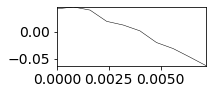

In [ ]:
fig = plt.figure(figsize=(12, len(models)+3))
gs = GridSpec(2+len(models), ncols, wspace=0.4, hspace=0.4, left=0.05, right=0.95, top=0.95, bottom=0.1)

for i in range(ncols):
    # raw LFP with ripple label
    if i == 0:
        ax0 = fig.add_subplot(gs[0, i])
    else:
        ax0 = fig.add_subplot(gs[0, i], sharey=ax0)
    ax0.plot(time, reshaped_X_val[i, ] - reshaped_X_val[i, ].mean(), 'k', lw=0.5,  
             label='__nolabel__')
    idx = all_labels['session'] == labels['session'][i]
    lbls = all_labels['rippleLocs'][idx] - labels[i]['rippleLocs'] - labels[i]['offset']
    inds = lbls[(lbls >= 0) & (lbls < Fs)]
    ax0.plot(time[inds], reshaped_X_val[i, inds] - reshaped_X_val[i, ].mean() + 0.4, 
             'D', mec='k', mfc='w', ms=8, label='SPW-R', clip_on=False)

    ax0.set_title(r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
    if i == 0:
        ax0.set_ylabel('(mV)', labelpad=0)
    if i == ncols - 1:
        ax0.legend(loc=(0.95, 0.2), frameon=False, handletextpad=0)
    ax0.axis(ax0.axis('tight'))
    if i > 0:
        plt.setp(ax0.get_yticklabels(), visible=False)
    for spine in ['top', 'bottom', 'right']:
        ax0.spines[spine].set_visible(False)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax0.xaxis.set_ticks_position('none')    

    # label vector
    ax1 = fig.add_subplot(gs[1, i], sharex=ax0)
    ax1.plot(time, reshaped_Y_val[i, ], 'k', lw=0.5, clip_on=False)
    ax1.text(time[0]-0.1, 0.5, r'$y^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$', ha='right', va='center')
    ax1.axis(ax1.axis('tight'))
    ax1.set_ylim(0, 1)
    ax1.set_yticks([0, 1])
    if i > 0:
        ax1.set_yticklabels([])
    for spine in ['top', 'bottom', 'right']:
        ax1.spines[spine].set_visible(False)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.xaxis.set_ticks_position('none')

    if i == 0:
        annotate_subplot(ax0, ncols=12, nrows=2+len(models), letter='a')
        annotate_subplot(ax1, ncols=12, nrows=2+len(models), letter='b')

    last_variant = None
    k = 0
    # show prediction for every model, with asterisks for predicted events
    for j, (Y_pred, f) in enumerate(zip(Y_preds, model_files)):
        variant = os.path.split(f)[1].split('_')[1]
        
        # find times of local peaks above threshold
        y = Y_pred[i, :, 0]
        peaks, props = ss.find_peaks(y, height=threshold, distance=distance, width=width)
        
        ax = fig.add_subplot(gs[j+2, i], sharex=ax0)  
        ax.plot(time, y, 'k', lw=0.5, clip_on=False)
        ax.text(time[0]-0.1, 0.5, 
                r'$\hat{y}_\mathrm{M' + '{}'.format(j+1) + '}^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$', 
                ha='right', va='center')
        ax.plot(time[peaks], y[peaks]+.1, 'D', mec='k', mfc='gray', ms=8, clip_on=False)            
        if j == len(Y_preds)-1:
            ax.plot([0.8, 0.9], [-0.05, -0.05], 'k-', lw=1, clip_on=False)
            ax.text(0.85, -0.1, '100 ms', va='top', ha='center')
        ax.set_ylim(0, 1)
        ax.set_xlim(time[0], time[-1])
        ax.set_yticks([0, 1])
        if i > 0:
            ax.set_yticklabels([])
        for spine in ['top', 'bottom', 'right']:
            ax.spines[spine].set_visible(False)
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.xaxis.set_ticks_position('none')
        
        if (i==0) & (variant != last_variant):
            annotate_subplot(ax, ncols=12, nrows=2+len(models), letter='cdefghijklmnopqrstuvwxyz'[k])
            k += 1
        last_variant = variant

# save figure
fig.savefig(os.path.join('figures', 'figure05.pdf'), dpi=300, bbox_inches='tight', pad_inches=0.05)
fig.savefig(os.path.join('figures', 'figure05.eps'), dpi=300, bbox_inches='tight', pad_inches=0.05)

# Quantify performance
Accuracy measures:
```
# Accuracy = (TP + TN) / (TP + TN + FP + FN) # can't quantify count of TN
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1 = 2 / (Precision^-1 + Recall^-1)
```

In [20]:
# container for stats
df = pd.DataFrame(columns=['Variant', 'Model', 'TP', 'FP', 'FN', 'FP+FN', 'Precision', 'Recall', 'F_1'], 
                  dtype='object')

# iterate over models
for i, (Y_pred, f) in enumerate(zip(Y_preds, model_files)):
    variant = os.path.split(f)[1].split('_')[1]
    variant = variant.replace('directional', 'dir.')
    
    # get metrics
    TP, FP, FN, precision, recall, F1 = get_metrics(reshaped_X_val, reshaped_Y_val, Y_pred, reshaped_labels, all_labels,
                                                    threshold, distance, width,
                                                    y_label_width=y_label_width, Fs=Fs)    
    
    # fill in dataframe
    row_df = pd.DataFrame([[variant, i+1, TP, FP, FN, FP+FN, precision, recall, F1]],
                          columns=['Variant', 'Model', 'TP', 'FP', 'FN', 'FP+FN', 'Precision', 'Recall', 'F_1'], 
                          dtype='object')
    
    df = pd.concat([df, row_df], axis=0, ignore_index=True)

# display dataframe
df

,Variant,Model,TP,FP,FN,FP+FN,Precision,Recall,F_1
0,unidir.,1,0,0,27500,27500,0,0,0
1,unidir.,2,0,0,27500,27500,0,0,0
2,unidir.,3,0,0,27500,27500,0,0,0


In [ ]:
print(labels.shape)

print(all_labels.shape)

(200,)
(4461,)


In [ ]:
print(df.to_latex(index=False))

In [ ]:
# convert columns to float so Pandas will agree to compute mean and std
df[['Model', 'TP', 'FP', 'FN', 'FP+FN', 'Precision', 'Recall', 'F_1']] = \
    df[['Model', 'TP', 'FP', 'FN', 'FP+FN', 'Precision', 'Recall', 'F_1']].astype(float)

In [ ]:
# mean
df_mean = df.groupby('Variant').mean().reset_index()
df_mean['Model'] = 'mean'
df_mean

In [ ]:
# std
df_std = df.groupby('Variant').std().reset_index()
df_std['Model'] = 'st.dev'
df_std

In [ ]:
# print out rows for pasting into .tex sources.
print(pd.concat([df_mean, df_std]).to_latex(index=False, float_format="%.3g"))

## figure 4
Training loss, test metrics

No handles with labels found to put in legend.
No handles with labels found to put in legend.


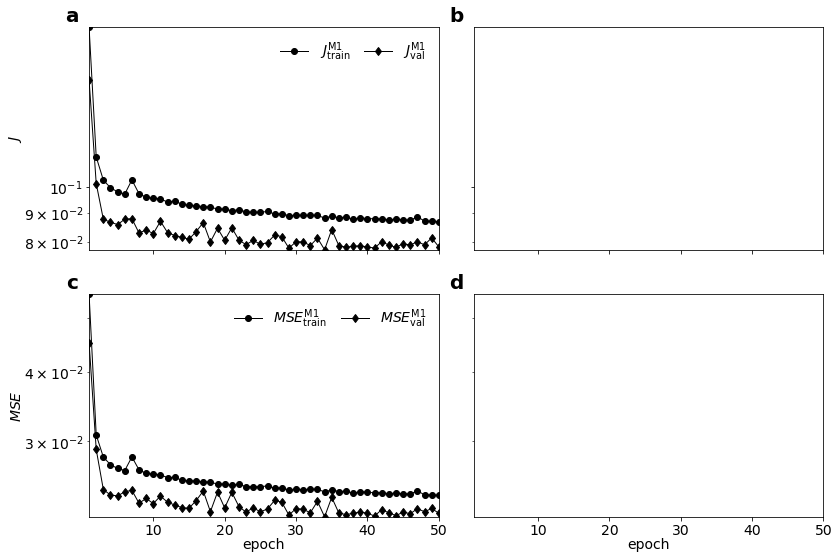

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey='row')
fig.subplots_adjust(wspace=0.1, left=0.1, right=0.95, bottom=0.1, top=0.95)
#gs = GridSpec(2, 2, wspace=0.3, left=0.1, right=0.95, bottom=0.1, top=0.95)


colors = [[0.]*3, [.33]*3, [0.66]*3]
lws = [1.]*3
#markers = ['o']*3 + ['d']*3


# plot training loss for the different models
for j in range(2):
    #ax0 = fig.add_subplot(gs[0, 0])
    ax = axes[0, j]
    for i, loss in enumerate(losses[j*3:(j+1)*3]):
        epochs = np.arange(len(loss['loss']))+1
        ax.semilogy(epochs, loss['loss'], '-o', alpha=1, color=colors[i], lw=lws[i], 
                    label=r'$J_\mathrm{train}^\mathrm{M%i}$' % int(j*3 + i + 1),
                   )
        ax.semilogy(epochs, loss['val_loss'], '-d', color=colors[i], lw=lws[i], alpha=1,
                     label=r'$J_\mathrm{val}^\mathrm{M%i}$' % int(j*3 + i + 1),
                    )
    if j == 0:
        ax.set_ylabel('$J$', labelpad=0)
    ax.legend(ncol=3, frameon=False, columnspacing=1)
    #if j != 0:
    #    ax.set_xlabel('Epoch', labelpad=0)
    annotate_subplot(ax, ncols=2, nrows=2, letter='ab'[j])


# plot training MSE
#ax1 = fig.add_subplot(gs[0, 1], sharex=ax0)
for j in range(2):
    ax = axes[1, j]
    for i, loss in enumerate(losses[j*3:(j+1)*3]):
        epochs = np.arange(len(loss['mse']))+1
        ax.semilogy(epochs, loss['mse'], '-o',  color=colors[i], lw=lws[i], alpha=1,
                    label=r'$MSE_\mathrm{train}^\mathrm{M%i}$' % int(j*3 + i + 1))
        ax.semilogy(epochs, loss['val_mse'], '-d', color=colors[i], lw=lws[i], alpha=1,
                    label=r'$MSE_\mathrm{val}^\mathrm{M%i}$' % int(j*3 + i + 1)
                )
    if j == 0:
        ax.set_ylabel('$MSE$', labelpad=0)
    ax.legend(ncol=3, frameon=False, columnspacing=1)
    ax.set_xlabel('epoch', labelpad=0)
    annotate_subplot(ax, ncols=2, nrows=2, letter='cd'[j])

# save figure
fig.savefig(os.path.join('figures', 'figure04.pdf'), dpi=300, bbox_inches='tight', pad_inches=0.05)
fig.savefig(os.path.join('figures', 'figure04.eps'), dpi=300, bbox_inches='tight', pad_inches=0.05)

## figure 6
Test dependence of (TP, FP, FN, precision, recall, F1) on threshold and width (ss.find_peaks hyperparameters)

In [ ]:
thresholds = np.linspace(0.1, 0.95, 18)
widths = np.linspace(0, 62.5, 11) #.astype(int) # width

In [ ]:
# container
df = pd.DataFrame(columns=['Variant', 'Model', 'threshold', 'width', 'TP', 'FP', 'FN', 'FP+FN', 
                           'Precision', 'Recall', 'F_1'], 
                  dtype='object')

for threshold_ in thresholds:
    for width_ in widths:
        # iterate over models
        for model, (Y_pred, f) in enumerate(zip(Y_preds, model_files)):
            variant = os.path.split(f)[1].split('_')[1]
            variant = variant.replace('directional', 'dir.')
            
            # get metrics
            TP, FP, FN, precision, recall, F1 = get_metrics(X_val, Y_val, Y_pred, labels, all_labels,
                                                            threshold_, distance, width_,
                                                            y_label_width=y_label_width, Fs=Fs)

            # fill in dataframe
            row_df = pd.DataFrame([[variant, model+1, threshold_, width_, 
                                    TP, FP, FN, FP+FN, precision, recall, F1]],
                                  columns=['Variant', 'Model', 'threshold', 'width', 
                                           'TP', 'FP', 'FN', 'FP+FN', 'Precision', 'Recall', 'F_1'], 
                                  dtype='object')

            df = pd.concat([df, row_df], axis=0, ignore_index=True)

# width in units of ms
df.insert(len(df.columns), 'width (ms)', df['width']*1000 / Fs)

# display dataframe
df

,Variant,Model,threshold,width,TP,FP,FN,FP+FN,Precision,Recall,F_1,width (ms)
0,unidir.,1,0.1,0,3,149,173,322,0.02,0.017,0.018,0
1,unidir.,1,0.1,6.25,0,0,258,258,0,0,0,5
2,unidir.,1,0.1,12.5,0,0,258,258,0,0,0,10
3,unidir.,1,0.1,18.8,0,0,258,258,0,0,0,15
4,unidir.,1,0.1,25,0,0,258,258,0,0,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...
193,unidir.,1,0.95,37.5,0,0,258,258,0,0,0,30
194,unidir.,1,0.95,43.8,0,0,258,258,0,0,0,35
195,unidir.,1,0.95,50,0,0,258,258,0,0,0,40
196,unidir.,1,0.95,56.2,0,0,258,258,0,0,0,45


In [ ]:
fig, axes = plt.subplots(len(models), 7, figsize=(12, len(models)+2), sharex=True, sharey=True)
from matplotlib.ticker import MaxNLocator

# container for optimal detection settings
df_opt = pd.DataFrame(columns=df.columns)

for j, column in enumerate(['TP', 'FP', 'FN', 'FP+FN', 'Precision', 'Recall', 'F_1']):
    values = [] # container to allow sharing colorbar
    for i in range(len(models)):
        df_ = df[df.Model==i+1][['threshold', 'width (ms)', column]]
        df_ = df_.pivot('threshold', 'width (ms)', column)
        values.append(df_.values.astype(float))
        if (i == 0) & (j == 0):
            x, y = np.meshgrid(df_.columns.values, df_.index.values)

    values = np.array(values)
    pc = np.percentile(values.flatten(), [1, 99])
    levels = np.linspace(pc[0], pc[1], 21)
    variant = None
    k = 0
    for i, f in enumerate(model_files):
        variant = os.path.split(f)[1].split('_')[1]
        
        ax = axes[i, j]
        if j == 0:
            ax.set_ylabel('thresh.', labelpad=0)
            annotate_subplot(ax, ncols=6, nrows=4, letter='M{}'.format(i+1), 
                             fontweight='normal', fontsize=14)
        if (j==0) & (variant != last_variant):
            annotate_subplot(ax, ncols=25, nrows=1, #len(models)*2, 
                             letter='abcdefghijklmnopqrstuvwxyz'[k])
            k += 1
        last_variant = variant


        df_ = df[df.Model==i+1][['threshold', 'width (ms)', column]]
        df_ = df_.pivot('threshold', 'width (ms)', column)
        im = ax.contourf(x, y, values[i], levels=levels, 
                         cmap='inferno_r' if column in ['FP', 'FN', 'FP+FN'] else 'inferno', 
                         extend='both')
        
        if column == 'F_1':
            inds = values[i] == values[i].max()
            for i_, j_ in np.c_[np.where(inds)]:
                df_opt = df_opt.append(df[(df['Model']==i+1) &
                                 (df['width (ms)']==x[i_, j_]) &
                                 (df['threshold']==y[i_, j_])],
                             ignore_index=True)
            ax.plot(x[inds], y[inds], 'kx')
            
            
        if i == len(models)-1:
            ax.set_xlabel('width (ms)', labelpad=0)
            rect = np.array(ax.get_position().bounds)
            rect[1] -= 0.08
            rect[3] = 0.01
            fig = plt.gcf()
            cax = fig.add_axes(rect)
            cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
            cbar.locator = MaxNLocator(nbins=2)
            cbar.update_ticks()
            
            cbar.set_label('${}$'.format(column), labelpad=0)

fig.savefig(os.path.join('figures', 'figure06.pdf'), dpi=300, bbox_inches='tight', pad_inches=0.05)
fig.savefig(os.path.join('figures', 'figure06.eps'), dpi=300, bbox_inches='tight', pad_inches=0.05)

In [ ]:
df_opt

In [ ]:
print(df_opt.to_latex(index=False))

In [ ]:
# mean thresholds and widths per model as multiple settings can result in similar F1 score (not used)
df_opt_copy = df_opt.copy()
df_opt_copy[['Model', 'threshold', 'width', 'width (ms)', 
             'TP', 'FP', 'FN', 'FP+FN', 'Precision', 'Recall', 'F_1']] = \
    df_opt_copy[['Model', 'threshold', 'width', 'width (ms)', 
                 'TP', 'FP', 'FN', 'FP+FN', 'Precision', 'Recall', 'F_1']].astype(float)

df_opt_copy.groupby(['Variant', 'Model']).mean()

In [ ]:
df_opt_mean = df_opt_copy.groupby(['Variant']).mean()
df_opt_mean.Model = 'mean'
df_opt_mean

In [ ]:
df_opt_std = df_opt_copy.groupby(['Variant']).std()
df_opt_std.Model = 'st.dev'
df_opt_std

In [ ]:
df_mean_std = pd.concat([df_opt_mean, df_opt_std])
df_mean_std

In [ ]:
# print out rows for pasting into .tex sources.
print(df_mean_std.to_latex(index=True, float_format="%.3g"))

In [ ]:
# save model file path and corresponding threshold and width
best_model_settings = []
for i, model_file in enumerate(model_files):
    best_model_settings += [dict(
        model_file = model_file,
        threshold = df_opt_mean.loc[i].threshold,
        width = df_opt_mean.loc[i].width,
        distance = distance
    )]
with open('best_model_settings.pkl', 'wb') as f:
    pickle.dump(best_model_settings, f)

## Figure 7, 8

In [ ]:
df_opt[df_opt.F_1 == df_opt.F_1.max()]

In [ ]:
# settings for the "best" model
row = df_opt.F_1 == df_opt.F_1.max()
threshold = df_opt[row].threshold.values[-1]
width = df_opt[row].width.values[-1]
Y_pred = Y_preds[df_opt[row].Model.values[-1] - 1]

In [ ]:
# which model file
model_files[df_opt[row].Model.values[-1] - 1]

In [ ]:
# write best model info to file for loading in other notebooks
best_model = dict(
    model_file=model_files[df_opt[row].Model.values[-1] - 1], 
    threshold=threshold,
    width=width,
    distance=distance,
)
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
TP, FP, FN, precision, recall, F1 = get_metrics(X_val, Y_val, Y_pred, labels, all_labels,
                                                    threshold, distance, width,
                                                    y_label_width=y_label_width, Fs=Fs)

In [ ]:
TPs, FPs, FNs = get_TPs_FPs_FNs(X_val, Y_val, Y_pred, X1, S, labels, all_labels, 
                                threshold, distance, width,
                                Fs=Fs, y_label_width=y_label_width)

In [ ]:
# plot validation set entries with FP mistakes (FP and/or FN predictions)
badinds = np.unique(FPs['i'])

for h in range(badinds.size // ncols):
    inds = badinds[h*ncols:(h+1)*ncols]

    fig, axes = plt.subplots(4, ncols, figsize=(12, 7), 
                            sharex=True, sharey='row')
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.925, wspace=0.1, hspace=0.4, )

    for i, ind in enumerate(inds):
        X_val_ = X_val[ind]
        Y_ = Y[ind, :].flatten()
        y = Y_pred[ind]
        X0_ = X0[ind]
        X1_ = X1[ind]
        S_ = S[ind]

        # Raw LFP + symbols for labels
        axes[0, i].plot(time, X0_, 'k', lw=0.5, label='__nolabel__')
        idx = all_labels['session'] == labels['session'][ind]
        lbls = all_labels['rippleLocs'][idx] - labels[ind]['rippleLocs'] - labels[ind]['offset']
        lblinds = lbls[(lbls >= 0) & (lbls < Fs)]
        axes[0, i].plot(time[lblinds], X0_[lblinds]+0.4, 
                        'D', mec='k', mfc='w', ms=8, label='SPW-R', clip_on=False)

        for spine in ['top', 'bottom', 'right']:
            axes[0, i].spines[spine].set_visible(False)
        plt.setp(axes[0, i].get_xticklabels(), visible=False)
        axes[0, i].xaxis.set_ticks_position('none')
        if i == ncols - 1:
            axes[0, i].legend(loc=(0.95, 0.2), frameon=False, handletextpad=0)
        
        # band-pass filtered LFP
        axes[1, i].plot(time, X1_, 'k', lw=0.5, label=r'$\phi_\mathrm{BP}^{\langle j \rangle}(t)$')    
        for spine in ['top', 'bottom', 'right']:
            axes[1, i].spines[spine].set_visible(False)
        plt.setp(axes[1, i].get_xticklabels(), visible=False)
        axes[1, i].xaxis.set_ticks_position('none')

        # Spectrograms
        vmin, vmax = np.exp(np.percentile(np.log(S), [1, 99]))
        im = axes[2, i].pcolormesh(time, S_freqs, S_.T, norm=colors.LogNorm(vmin=vmin, vmax=vmax), 
                                   cmap='inferno',
                                   rasterized=True)
        if i == inds.size-1:
            rect = np.array(axes[2, i].get_position().bounds)
            rect[0] += rect[2] + 0.01
            rect[2] = 0.01
            fig = plt.gcf()
            cax = fig.add_axes(rect)
            
            cbar = fig.colorbar(im, cax=cax, extend='both')
            cbar.set_ticks(10.**np.arange(-6, 5))
            cbar.set_label('(a.u.)', labelpad=0)

        # plot one-hot encoding
        #axes[3, i].plot(time, Y_, 'gray', lw=0.5, label='__nolabel__', clip_on=False)

        # plot \hat{y} + predictions
        axes[3, i].plot(time, y, 'k', lw=0.5, label='__nolabel__', #label='$\hat{y}(t)$', 
                        clip_on=False)

        # mark TP events:
        j = TPs['j'][TPs['i'] == ind]
        axes[3, i].plot(time[j], y[j]+0.1, 'D', mec='k', mfc='gray', ms=8, label='TP', clip_on=False) 

        # mark FP events:
        j = FPs['j'][FPs['i'] == ind]
        axes[3, i].plot(time[j], y[j]+0.1, '^', mec='k', mfc='gray', ms=8, label='FP', clip_on=False) 

        # mark FN events:
        j = FNs['j'][FNs['i'] == ind]
        axes[3, i].plot(time[j], y[j]+0.1, 'v', mec='k', mfc='gray', ms=8, label='FN', clip_on=False) 

        if i == ncols-1:
            axes[3, i].legend(loc=(0.95, 0.2), frameon=False, handletextpad=0)


        axes[3, i].plot([0.8, 0.9], [-0.05, -0.05], 'k-', lw=1, clip_on=False)
        axes[3, i].text(0.85, -0.1, '100 ms', va='top', ha='center')
        axes[3, i].set_ylim(0, 1.1)
        axes[3, i].set_xlim(time[0], time[-1])
        axes[3, i].set_yticks([0, 1])
        for spine in ['top', 'bottom', 'right']:
            axes[3, i].spines[spine].set_visible(False)
        plt.setp(axes[3, i].get_xticklabels(), visible=False)
        axes[3, i].xaxis.set_ticks_position('none')


        axes[0, i].set_title(r'$X^{\langle ' + str(ind+1)+ r' \rangle}(t)$')
        axes[1, i].set_title(r'$\phi_\mathrm{BP}^{\langle ' + str(ind+1)+ r' \rangle}(t)$')
        axes[2, i].set_title(r'$S^{\langle ' + str(ind+1)+ r' \rangle}(t, f)$')
        axes[3, i].set_title(r'$\hat{y}^{\langle ' + str(ind+1)+ r' \rangle}(t)$')
        
        if i == 0:
            axes[0, i].set_ylabel('(mV)', labelpad=0)
            axes[1, i].set_ylabel('(mV)', labelpad=0)
            axes[2, i].set_ylabel('$f$ (Hz)', labelpad=0)
            axes[3, i].set_ylabel('$\hat{y}$', labelpad=0)

            annotate_subplot(axes[0, i], ncols=10, nrows=4, letter='a')
            annotate_subplot(axes[1, i], ncols=10, nrows=4, letter='b')
            annotate_subplot(axes[2, i], ncols=10, nrows=4, letter='c')
            annotate_subplot(axes[3, i], ncols=10, nrows=4, letter='d')
    
    fig.savefig(os.path.join('figures', 'figure07_{:02}.pdf'.format(h)), 
                dpi=300, bbox_inches='tight', pad_inches=0.05)
    fig.savefig(os.path.join('figures', 'figure07_{:02}.eps'.format(h)), 
                dpi=300, bbox_inches='tight', pad_inches=0.05)

In [ ]:
# plot validation set entries with FN mistakes. 
# Drop entries shown together with FP mistakes
badinds = np.unique(FNs['i'])
for i in np.unique(FPs['i']):
    badinds = badinds[badinds != i]

for h in range(badinds.size // ncols):
    inds = badinds[h*ncols:(h+1)*ncols]

    fig, axes = plt.subplots(4, ncols, figsize=(12, 7), 
                            sharex=True, sharey='row')
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.925, wspace=0.1, hspace=0.4, )

    for i, ind in enumerate(inds):
        X_val_ = X_val[ind]
        Y_ = Y[ind, :].flatten()
        y = Y_pred[ind]
        X0_ = X0[ind]
        X1_ = X1[ind]
        S_ = S[ind]

        # Raw LFP + symbols for labels
        axes[0, i].plot(time, X0_, 'k', lw=0.5, label='__nolabel__')
        idx = all_labels['session'] == labels['session'][ind]
        lbls = all_labels['rippleLocs'][idx] - labels[ind]['rippleLocs'] - labels[ind]['offset']
        lblinds = lbls[(lbls >= 0) & (lbls < Fs)]
        axes[0, i].plot(time[lblinds], X0_[lblinds]+0.4, 
                        'D', mec='k', mfc='w', ms=8, label='SPW-R', clip_on=False)

        for spine in ['top', 'bottom', 'right']:
            axes[0, i].spines[spine].set_visible(False)
        plt.setp(axes[0, i].get_xticklabels(), visible=False)
        axes[0, i].xaxis.set_ticks_position('none')
        if i == ncols - 1:
            axes[0, i].legend(loc=(0.95, 0.2), frameon=False, handletextpad=0)
        
        # band-pass filtered LFP
        axes[1, i].plot(time, X1_, 'k', lw=0.5, label=r'$\phi_\mathrm{BP}^{\langle j \rangle}(t)$')    
        for spine in ['top', 'bottom', 'right']:
            axes[1, i].spines[spine].set_visible(False)
        plt.setp(axes[1, i].get_xticklabels(), visible=False)
        axes[1, i].xaxis.set_ticks_position('none')

        # Spectrograms
        vmin, vmax = np.exp(np.percentile(np.log(S), [1, 99]))
        im = axes[2, i].pcolormesh(time, S_freqs, S_.T, norm=colors.LogNorm(vmin=vmin, vmax=vmax), 
                                   cmap='inferno',
                                   rasterized=True)
        if i == inds.size-1:
            rect = np.array(axes[2, i].get_position().bounds)
            rect[0] += rect[2] + 0.01
            rect[2] = 0.01
            fig = plt.gcf()
            cax = fig.add_axes(rect)
            
            cbar = fig.colorbar(im, cax=cax, extend='both')
            cbar.set_ticks(10.**np.arange(-6, 5))
            cbar.set_label('(a.u.)', labelpad=0)

        # plot one-hot encoding
        #axes[3, i].plot(time, Y_, 'gray', lw=0.5, label='__nolabel__', clip_on=False)

        # plot \hat{y} + predictions
        axes[3, i].plot(time, y, 'k', lw=0.5, label='__nolabel__', #label='$\hat{y}(t)$', 
                        clip_on=False)

        # mark TP events:
        j = TPs['j'][TPs['i'] == ind]
        axes[3, i].plot(time[j], y[j]+0.1, 'D', mec='k', mfc='gray', ms=8, label='TP', clip_on=False) 

        # mark FP events:
        j = FPs['j'][FPs['i'] == ind]
        axes[3, i].plot(time[j], y[j]+0.1, '^', mec='k', mfc='gray', ms=8, label='FP', clip_on=False) 

        # mark FN events:
        j = FNs['j'][FNs['i'] == ind]
        axes[3, i].plot(time[j], y[j]+0.1, 'v', mec='k', mfc='gray', ms=8, label='FN', clip_on=False) 

        if i == ncols-1:
            axes[3, i].legend(loc=(0.95, 0.2), frameon=False, handletextpad=0)


        axes[3, i].plot([0.8, 0.9], [-0.05, -0.05], 'k-', lw=1, clip_on=False)
        axes[3, i].text(0.85, -0.1, '100 ms', va='top', ha='center')
        axes[3, i].set_ylim(0, 1.1)
        axes[3, i].set_xlim(time[0], time[-1])
        axes[3, i].set_yticks([0, 1])
        for spine in ['top', 'bottom', 'right']:
            axes[3, i].spines[spine].set_visible(False)
        plt.setp(axes[3, i].get_xticklabels(), visible=False)
        axes[3, i].xaxis.set_ticks_position('none')


        axes[0, i].set_title(r'$X^{\langle ' + str(ind+1)+ r' \rangle}(t)$')
        axes[1, i].set_title(r'$\phi_\mathrm{BP}^{\langle ' + str(ind+1)+ r' \rangle}(t)$')
        axes[2, i].set_title(r'$S^{\langle ' + str(ind+1)+ r' \rangle}(t, f)$')
        axes[3, i].set_title(r'$\hat{y}^{\langle ' + str(ind+1)+ r' \rangle}(t)$')
        
        if i == 0:
            axes[0, i].set_ylabel('(mV)', labelpad=0)
            axes[1, i].set_ylabel('(mV)', labelpad=0)
            axes[2, i].set_ylabel('$f$ (Hz)', labelpad=0)
            axes[3, i].set_ylabel('$\hat{y}$', labelpad=0)

            annotate_subplot(axes[0, i], ncols=10, nrows=4, letter='a')
            annotate_subplot(axes[1, i], ncols=10, nrows=4, letter='b')
            annotate_subplot(axes[2, i], ncols=10, nrows=4, letter='c')
            annotate_subplot(axes[3, i], ncols=10, nrows=4, letter='d')
    
    fig.savefig(os.path.join('figures', 'figure08_{:02}.pdf'.format(h)), 
                dpi=300, bbox_inches='tight', pad_inches=0.05)
    fig.savefig(os.path.join('figures', 'figure08_{:02}.eps'.format(h)), 
                dpi=300, bbox_inches='tight', pad_inches=0.05)